In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import graphviz

In [2]:
# Loads the data into a dataframe
df = pd.read_csv('./data/Jan_2019_ontime.csv')
df2 = pd.read_csv('./data/Jan_2020_ontime.csv')
df.append(df2)
df.shape

(583985, 22)

In [3]:
# baseline
df.ARR_DEL15.value_counts()
base_acc = 460741 / (460741 + 105222)
print('baseline acc', base_acc)

baseline acc 0.8140832527921437


In [4]:
# Drops column with no data and reduces the data to just a small sample for establishing a baseline
df = df.sample(frac=0.05)
df = df.drop(['Unnamed: 21', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'OP_CARRIER_AIRLINE_ID',
             'DEP_TIME_BLK', 'DEP_DEL15', 'ARR_TIME', 'CANCELLED', 'DIVERTED'], axis=1)
df = df.dropna()
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_DEL15,DISTANCE
294484,16,3,DL,N902DE,1837,ATL,ORF,1528.0,0.0,516.0
7528,1,2,WN,N7746C,2160,LAS,DSM,846.0,0.0,1216.0
570039,31,4,B6,N962JB,624,LAX,JFK,1408.0,0.0,2475.0
330214,18,5,WN,N8576Z,239,SMF,DEN,1304.0,1.0,909.0
346787,19,6,AA,N820AW,608,PHX,IND,1106.0,0.0,1488.0


In [5]:
# Splits data into test and training sets
X = df.drop('ARR_DEL15', axis=1)
y = df.ARR_DEL15
X.OP_CARRIER_FL_NUM = X.OP_CARRIER_FL_NUM.astype('category')
X.DAY_OF_WEEK = X.DAY_OF_WEEK.astype('category')
X.OP_CARRIER_FL_NUM = X.OP_CARRIER_FL_NUM.astype('category')
X.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DISTANCE
294484,16,3,DL,N902DE,1837,ATL,ORF,1528.0,516.0
7528,1,2,WN,N7746C,2160,LAS,DSM,846.0,1216.0
570039,31,4,B6,N962JB,624,LAX,JFK,1408.0,2475.0
330214,18,5,WN,N8576Z,239,SMF,DEN,1304.0,909.0
346787,19,6,AA,N820AW,608,PHX,IND,1106.0,1488.0


In [6]:
# One-hot-encodes categorical features and standardizes numerical features
X_num = X[['DEP_TIME', 'DISTANCE']]
# X_num = (X_num - X_num.mean())/X_num.std()
X_cat = X.drop(['DEP_TIME', 'DISTANCE'], axis=1)
X_cat = pd.get_dummies(X_cat)
X = X_num.join(X_cat)
X.head()

,DEP_TIME,DISTANCE,DAY_OF_MONTH,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,...,DEST_TYS,DEST_UIN,DEST_USA,DEST_VEL,DEST_VLD,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YUM
294484,1528.0,516.0,16,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7528,846.0,1216.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570039,1408.0,2475.0,31,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
330214,1304.0,909.0,18,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
346787,1106.0,1488.0,19,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Decision Tree
tree = DecisionTreeClassifier(max_depth = 9)
tree.fit(X,y)

DecisionTreeClassifier(max_depth=9)

In [21]:
y_predict = tree.predict(X)

from sklearn.metrics import accuracy_score
# Accuracy
accuracy_score(y, y_predict)

0.8400437945892492

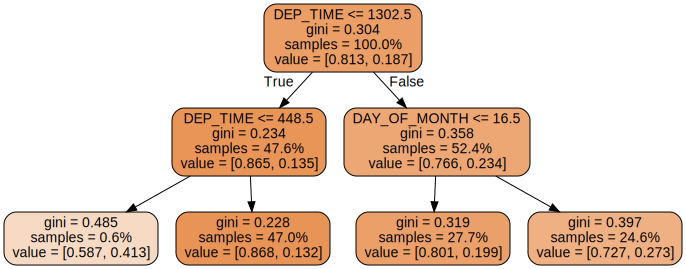

In [19]:
dot_data = export_graphviz(tree,
                           out_file=None,
                           feature_names=X.columns,
                           proportion=True,
                           impurity=True,
                           filled=True,
                           rounded=True)
graph = graphviz.Source(dot_data)
graph

In [9]:
# Validation
grid = {'max_depth': np.arange(1, 10)}
tree = DecisionTreeClassifier()
treeCV = GridSearchCV(tree, param_grid=grid, return_train_score=True)

treeCV.fit(X, y)

print('best tree depth', treeCV.best_params_)

print('valid error rate', (1 - treeCV.best_score_).round(3))

best tree depth {'max_depth': 9}
valid error rate 0.179


In [10]:
val_accuracy = treeCV.best_score_
print('valid acc', val_accuracy.round(3))

valid acc 0.821


<AxesSubplot:xlabel='depth'>

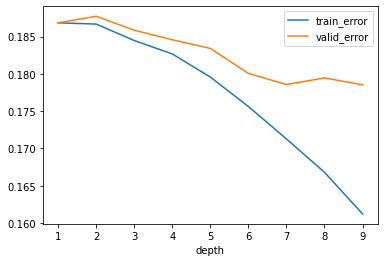

In [11]:
results = pd.DataFrame()
results['depth'] = grid['max_depth']
results['train_error'] = 1 - treeCV.cv_results_['mean_train_score']
results['valid_error'] = 1 - treeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x = 'depth', y = 'train_error')
results.plot.line(x = 'depth', y = 'valid_error', ax = ax1)